In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import os
import squidpy as sq
from sklearn.preprocessing import LabelEncoder
import json

import torch
import torchsde
from torchdyn.core import NeuralODE
from tqdm import tqdm
import pickle
from src.ode_helper_functions import *
from src.data_loading import preprocess_data, process_data, get_batch, get_batch_interpolation
from src.plots import plot_trajectories, plot_trajectories_new
# from src.evaluate import *

from src.evaluate_for_sankey import *

from torchcfm.conditional_flow_matching import *
from torchcfm.models import MLP, GradModel, Graph_like_transformer
from torchcfm.utils import torch_wrapper

from sklearn.model_selection import train_test_split, KFold
import argparse

MODEL_REGISTRY = {
    "mlp": MLP,
    "graph_like_transformer": Graph_like_transformer,
    "gradmodel": GradModel,
    # Add more models here as needed
}

## cell-type static traj

In [16]:
# load scrna and multi_class_clf and label_encoder
# scRNA = sc.read_h5ad('/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE232025_stereoseq_g_10000_nzp_0.1.h5ad')
# multi_class_clf= pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE232025/multi_class_clf.pkl', 'rb'))
# label_encoder = pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE232025/label_encoder.pkl', 'rb'))

# scRNA = sc.read_h5ad('/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE062025_MOSTA_g_10000_nzp_0.1.h5ad')
# multi_class_clf= pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE062025/multi_class_clf.pkl', 'rb'))
# label_encoder = pickle.load(open(f'/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/metadata/cell_label_encoder_GSE062025/label_encoder.pkl', 'rb'))


scRNA= sc.read_h5ad('/Users/rssantanu/Desktop/codebase/constrained_FM/datasets/h5ad_processed_datasets/GSE092025_liver_g_10000_nzp_0.006.h5ad')

/Users/rssantanu/anaconda3/envs/torch_flow_matching/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
## parameters

# # GSE232025

## EOT
# params= json.load(open('/Users/rssantanu/Desktop/codebase/constrained_FM/train_configs/post_prior_correction/vi_pca_C_g_EOT.json'))

## REOT with reg and lr
# params= json.load(open('/Users/rssantanu/Desktop/codebase/constrained_FM/train_configs/post_prior_correction/vi_pca_C_g_REOT1_lr.json'))


## REOT with reg and mc
# params= json.load(open('/Users/rssantanu/Desktop/codebase/constrained_FM/train_configs/post_prior_correction/vi_pca_C_g_REOT1_mc.json'))

params= json.load(open('/Users/rssantanu/Desktop/codebase/constrained_FM/train_configs/post_prior_correction/vi_pca_C_g_REOT3_mc+lr.json'))



# # GSE062025
# params = {
#     "cfm_model": "mlp",
#     "dim": 50,
#     "out_dim": 50,
#     "time_varying": True,
#     "w": 100,
#     "use_celltype_conditional": False,
#     "trajectory_steps": 400,
# }

cell_type_key = 'celltype'
total_times = len(scRNA.obs['day'].unique())

# # # GSE232025
# train_idx = [0, 1, 2, 3]
# test_idx = [4]

# # GSE062025
# train_idx = [0, 1, 2, 3, 4, 5, 6]
# test_idx = [7]

# GSE092025
train_idx = [1, 2]
test_idx = [1]

cond_dim=0
device = 'cuda' if torch.cuda.is_available() else 'cpu'










In [18]:
import pickle


X_raw, data_df = preprocess_data(scRNA)
X_phate, X_phate_conditional, Spatial, Celltype_list, microenvironment_features, LR_features = process_data(scRNA, X_raw, cell_type_key, total_times, False, False, False, 'pca')
        

# load train/test data
train_idx, test_idx = sorted(train_idx), sorted(test_idx)


# always include the first timepoint in the training set
X_phate_train= [X_phate[i] for i in [0]+train_idx]
X_phate_conditional_train = [X_phate_conditional[i] for i in [0]+train_idx]

X_phate_test= [X_phate[i] for i in test_idx]
X_phate_conditional_test = [X_phate_conditional[i] for i in test_idx]



Spatial_train = [Spatial[i] for i in [0]+train_idx]
Spatial_test = [Spatial[i] for i in test_idx]

Celltype_list_train = [Celltype_list[i] for i in [0]+train_idx]
Celltype_list_test = [Celltype_list[i] for i in test_idx]

microenvironment_features_train = [microenvironment_features[i] for i in [0]+train_idx]
microenvironment_features_test = [microenvironment_features[i] for i in test_idx]

LR_features_train = [LR_features[i] for i in [0]+train_idx]
LR_features_test = [LR_features[i] for i in test_idx]


n_times = len(X_phate_train)


Day 0: 3075 cells, X_raw[0]: (3075, 2000)
Day 1: 3457 cells, X_raw[1]: (9266, 2000)
Day 2: 2734 cells, X_raw[2]: (2734, 2000)


In [19]:
def get_batch(FM, X, X_conditional, batch_size, n_times, return_noise=False, Spatial=[], Celltype_list=[], microenvironment_features=[], LR_features=[], device=None, params=None, replace=True):
    """Construct a batch with point sfrom each timepoint pair"""
    
    all_x0_i = []
    all_x1_j = []
    all_ct0_i = []
    all_ct1_j = []
    all_mc0_i = []
    all_mc1_j = []
    all_lr0_i = []
    all_lr1_j = []
    all_p0_i = []
    all_p1_j = []

    for t_start in range(n_times - 1):

        try:
            b0= np.random.randint(X[t_start].shape[0], size=batch_size)
            b1= np.random.randint(X[t_start+1].shape[0], size=batch_size)
        except:
            import pdb; pdb.set_trace()


        # import pdb; pdb.set_trace()
        x0 = (torch.from_numpy(X[t_start][b0]).float().to(device))
        x0_conditional= (torch.from_numpy(X_conditional[t_start][b0]).float().to(device))

        if len(Celltype_list) > 0:
            ct0= np.array(Celltype_list[t_start])[b0]
            ct1= np.array(Celltype_list[t_start+1])[b1]
        else:
            ct0= None
            ct1= None
        
        # notice that it's shape[0] here
        x1 = (
            torch.from_numpy(
                X[t_start + 1][b1]
            )
            .float()
            .to(device)
        )
        x1_conditional= (
            torch.from_numpy(X_conditional[t_start+1][b1])
        ).float().to(device)
        
        if len(Spatial) > 0:
            p0= torch.from_numpy(Spatial[t_start][b0]).float().to(device)
            p1= torch.from_numpy(Spatial[t_start+1][b1]).float().to(device)
        else:
            p0= None
            p1= None

        if len(microenvironment_features) > 0:
            mc0= torch.from_numpy(microenvironment_features[t_start][b0]).float().to(device)
            mc1= torch.from_numpy(microenvironment_features[t_start+1][b1]).float().to(device)
        else:
            mc0= None
            mc1= None
            
        if len(LR_features) > 0:
            lr0= torch.from_numpy(LR_features[t_start][b0]).float().to(device)
            lr1= torch.from_numpy(LR_features[t_start+1][b1]).float().to(device)
        else:
            lr0= None
            lr1= None
        

        lambda_= params['lambda_']
        lambda_bio_prior= params['lambda_bio_prior']
        method= params['ot_method']
        cc_communication_type= params['cc_communication_type']

        pi = FM.ot_sampler.get_map(x0, x1, p0, p1, ct0, ct1, mc0, mc1, lr0, lr1, method=method, cc_index=0, params=params)
        i, j = FM.ot_sampler.sample_map(pi, x0.shape[0], replace=replace)

        x0_i, x1_j = x0[i], x1[j]
        ct0_i, ct1_j = ct0[i], ct1[j]
        mc0_i, mc1_j = mc0[i], mc1[j]
        lr0_i, lr1_j = lr0[i], lr1[j]
        p0_i, p1_j = p0[i], p1[j]

        all_x0_i.append(x0_i)
        all_x1_j.append(x1_j)
        all_ct0_i.append(ct0_i)
        all_ct1_j.append(ct1_j)
        all_mc0_i.append(mc0_i)
        all_mc1_j.append(mc1_j)
        all_lr0_i.append(lr0_i)
        all_lr1_j.append(lr1_j)
        all_p0_i.append(p0_i)
        all_p1_j.append(p1_j)

    return all_x0_i, all_x1_j, all_ct0_i, all_ct1_j, all_mc0_i, all_mc1_j, all_lr0_i, all_lr1_j, all_p0_i, all_p1_j

        

In [20]:
if 'ot_method' in params and 'entropy_reg' in params:
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=params['sigma'], ot_method=params['ot_method'], entropy_reg=params['entropy_reg'])
else:
    FM = ExactOptimalTransportConditionalFlowMatcher(sigma=params['sigma'])

batch_size= 1000

all_x0_i, all_x1_j, all_ct0_i, all_ct1_j, all_mc0_i, all_mc1_j, all_lr0_i, all_lr1_j, all_p0_i, all_p1_j = get_batch(FM, X_phate, X_phate_conditional, batch_size, n_times, return_noise=False, Spatial=Spatial, Celltype_list=Celltype_list, microenvironment_features=microenvironment_features, LR_features=LR_features, device=device, params=params, replace=True)

transitions = [[f'{i}->{j}' for i,j in zip(all_ct0_i[k], all_ct1_j[k])] for k in range(len(all_ct0_i))]







# 

/Users/rssantanu/Desktop/codebase/constrained_FM/ot_modified/bregman/_sinkhorn.py:1499: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
/Users/rssantanu/Desktop/codebase/constrained_FM/ot_modified/bregman/_sinkhorn.py:1507: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/Users/rssantanu/Desktop/codebase/constrained_FM/torchcfm/optimal_transport.py:286: UserWarning: Numerical errors in OT plan, reverting to uniform plan.
  warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")


In [21]:
from collections import Counter
transitions_counter = Counter(transitions[0])
transitions_counter

Counter({'0.0->0.0': 610, '1.0->0.0': 236, '0.0->1.0': 119, '1.0->1.0': 35})

In [22]:
'''
EOTFM d0-d1:
{'dEGC->dEGC': 77,
         'dEGC->CP': 44,
         'Immature MSN->Immature MSN': 28,
         'dEGC->dNBL1': 27,
         'dEGC->VLMC': 25,
         'CP->CP': 25,
         'CP->VLMC': 22,
         'VLMC->VLMC': 22,
         'Immature MSN->Immature nptxEX': 22,
         'dEGC->wntEGC': 22,
         'Immature MSN->Immature cckIN': 19,
         'VLMC->CP': 19,
         'dNBL1->dEGC': 16,
         'dNBL1->CP': 16,
         'Immature MSN->Immature mpEX': 16,
         'Immature nptxEX->Immature nptxEX': 16,
         'dEGC->dNBL4': 15,
         'dEGC->dNBL2': 13,
         'dEGC->sfrpEGC': 13,
         'dEGC->Immature cckIN': 12,
         'VLMC->Immature cckIN': 12,
         'Immature MSN->Immature CMPN': 12,
         'dNBL1->Immature MSN': 12,
         'Immature MSN->dNBL1': 11,
         'dNBL2->dEGC': 11,
         'dNBL1->Immature mpEX': 10,
         'Immature CMPN->Immature MSN': 10,
         'CP->Immature cckIN': 10,
         'Immature CMPN->CP': 10,
         'dNBL1->dNBL1': 10,
         'Immature CMPN->Immature cckIN': 9,
         'Immature MSN->VLMC': 9,
         'dNBL1->VLMC': 9,
         'dNBL1->Immature nptxEX': 9,
         'dEGC->Immature mpEX': 9,
         'CP->wntEGC': 8,
         'dNBL2->Immature cckIN': 8,
         'dNBL1->Immature cckIN': 8,
         'dEGC->Immature dpEX': 8,
         'Immature MSN->Immature dpEX': 7,
         'dNBL2->dNBL1': 7,
         'VLMC->Immature CMPN': 7,
         'dNBL1->Immature CMPN': 7,
         'dNBL2->CP': 7,
         'Immature nptxEX->Immature MSN': 7,
         'CP->dEGC': 7,
         'dNBL2->VLMC': 7,
         'dEGC->Immature MSN': 7,
         'dEGC->Immature nptxEX': 7,
         'Immature nptxEX->Immature cckIN': 7,
         'Immature CMPN->Immature nptxEX': 6,
         'dNBL3->VLMC': 6,
         'dNBL3->Immature nptxEX': 6,
         'VLMC->dEGC': 6,
         'Immature MSN->CP': 6,
         'dNBL3->Immature cckIN': 6,
         'Immature CMPN->Immature mpEX': 6,
         'dEGC->dNBL5': 6,
         'dNBL2->dNBL2': 6,
         'dNBL2->dNBL4': 6,
         'dEGC->Immature CMPN': 6,
         'dNBL2->Immature dpEX': 6,
         'CP->dNBL5': 5,
         'CP->Immature mpEX': 5,
         'dNBL1->dNBL4': 5,
         'dNBL1->dNBL2': 5,
         'dNBL3->Immature MSN': 5,
         'dNBL3->CP': 5,
         'dNBL3->dEGC': 5,
         'VLMC->Immature MSN': 5,
         'dNBL1->sfrpEGC': 5,
         'Immature nptxEX->Immature mpEX': 4,
         'Immature CMPN->VLMC': 4,
         'CP->sfrpEGC': 4,
         'CP->Immature nptxEX': 4,
         'dNBL3->dNBL2': 4,
         'dNBL2->Immature mpEX': 4,
         'Immature CMPN->Immature CMPN': 4,
         'VLMC->Immature nptxEX': 4,
         'dNBL3->Immature mpEX': 4,
         'dNBL1->Immature dpEX': 4,
         'CP->Immature MSN': 4,
         'Immature MSN->dNBL2': 4,
         'VLMC->Immature mpEX': 4,
         'VLMC->dNBL2': 4,
         'CP->Immature DMIN': 3,
         'dNBL1->wntEGC': 3,
         'VLMC->dNBL4': 3,
         'VLMC->dNBL1': 3,
         'Immature nptxEX->dNBL2': 3,
         'Immature MSN->Immature DMIN': 3,
         'Immature nptxEX->dEGC': 3,
         'Immature CMPN->dEGC': 3,
         'Immature CMPN->wntEGC': 3,
         'VLMC->Immature dpEX': 3,
         'Immature CMPN->dNBL1': 3,
         'CP->dNBL4': 3,
         'Immature nptxEX->Immature CMPN': 3,
         'dNBL1->dNBL5': 3,
         'Immature MSN->dNBL5': 2,
         'Immature CMPN->Immature dpEX': 2,
         'Immature CMPN->dNBL4': 2,
         'dNBL2->Immature MSN': 2,
         'CP->Immature dpEX': 2,
         'dNBL3->dNBL4': 2,
         'dNBL2->Immature nptxEX': 2,
         'Immature MSN->dNBL4': 2,
         'CP->dNBL1': 2,
         'dNBL3->dNBL1': 2,
         'CP->dNBL2': 2,
         'dNBL2->sfrpEGC': 2,
         'Immature nptxEX->wntEGC': 2,
         'Immature nptxEX->Immature dpEX': 2,
         'Immature nptxEX->dNBL1': 2,
         'Immature nptxEX->VLMC': 2,
         'VLMC->wntEGC': 2,
         'Immature nptxEX->CP': 1,
         'Immature MSN->wntEGC': 1,
         'VLMC->sfrpEGC': 1,
         'dNBL3->sfrpEGC': 1,
         'dNBL3->wntEGC': 1,
         'dNBL3->Immature DMIN': 1,
         'Immature CMPN->Immature DMIN': 1,
         'Immature MSN->sfrpEGC': 1,
         'dNBL2->Immature DMIN': 1,
         'Immature MSN->dEGC': 1,
         'dNBL2->Immature CMPN': 1,
         'Immature CMPN->dNBL2': 1,
         'CP->Immature CMPN': 1,
         'dEGC->Immature DMIN': 1,
         'dNBL1->Immature DMIN': 1,
         'Immature CMPN->sfrpEGC': 1,
         'Immature nptxEX->dNBL5': 1,
         'dNBL3->Immature dpEX': 1,
         'dNBL2->wntEGC': 1,
         'Immature CMPN->dNBL5': 1}
'''

"\nEOTFM d0-d1:\n{'dEGC->dEGC': 77,\n         'dEGC->CP': 44,\n         'Immature MSN->Immature MSN': 28,\n         'dEGC->dNBL1': 27,\n         'dEGC->VLMC': 25,\n         'CP->CP': 25,\n         'CP->VLMC': 22,\n         'VLMC->VLMC': 22,\n         'Immature MSN->Immature nptxEX': 22,\n         'dEGC->wntEGC': 22,\n         'Immature MSN->Immature cckIN': 19,\n         'VLMC->CP': 19,\n         'dNBL1->dEGC': 16,\n         'dNBL1->CP': 16,\n         'Immature MSN->Immature mpEX': 16,\n         'Immature nptxEX->Immature nptxEX': 16,\n         'dEGC->dNBL4': 15,\n         'dEGC->dNBL2': 13,\n         'dEGC->sfrpEGC': 13,\n         'dEGC->Immature cckIN': 12,\n         'VLMC->Immature cckIN': 12,\n         'Immature MSN->Immature CMPN': 12,\n         'dNBL1->Immature MSN': 12,\n         'Immature MSN->dNBL1': 11,\n         'dNBL2->dEGC': 11,\n         'dNBL1->Immature mpEX': 10,\n         'Immature CMPN->Immature MSN': 10,\n         'CP->Immature cckIN': 10,\n         'Immature CMPN->C

In [23]:
'''
REOT1_lr 0-1


{'dEGC->dEGC': 96,
         'dEGC->CP': 53,
         'Immature MSN->Immature MSN': 36,
         'dEGC->VLMC': 24,
         'Immature MSN->Immature cckIN': 23,
         'Immature MSN->Immature nptxEX': 23,
         'dEGC->wntEGC': 23,
         'dEGC->dNBL1': 21,
         'CP->CP': 19,
         'Immature MSN->Immature dpEX': 17,
         'dEGC->Immature cckIN': 16,
         'dEGC->dNBL4': 16,
         'CP->VLMC': 16,
         'dEGC->dNBL2': 15,
         'VLMC->CP': 13,
         'VLMC->VLMC': 13,
         'CP->dEGC': 13,
         'dEGC->Immature MSN': 13,
         'Immature CMPN->Immature MSN': 12,
         'Immature MSN->Immature mpEX': 12,
         'Immature CMPN->Immature cckIN': 12,
         'dNBL1->dEGC': 11,
         'VLMC->Immature MSN': 11,
         'Immature MSN->Immature CMPN': 11,
         'dEGC->sfrpEGC': 11,
         'Immature CMPN->Immature mpEX': 11,
         'dNBL2->dEGC': 10,
         'Immature nptxEX->Immature cckIN': 10,
         'dNBL3->Immature cckIN': 10,
         'dNBL1->Immature MSN': 10,
         'VLMC->dEGC': 10,
         'dNBL2->CP': 9,
         'dNBL2->VLMC': 9,
         'dNBL2->Immature mpEX': 9,
         'dNBL1->CP': 9,
         'dEGC->Immature mpEX': 9,
         'Immature CMPN->Immature nptxEX': 9,
         'dEGC->Immature CMPN': 9,
         'Immature CMPN->Immature CMPN': 9,
         'Immature nptxEX->Immature dpEX': 9,
         'CP->Immature cckIN': 8,
         'dNBL2->Immature MSN': 8,
         'dEGC->Immature nptxEX': 8,
         'dNBL2->Immature nptxEX': 7,
         'Immature nptxEX->Immature nptxEX': 7,
         'dNBL1->Immature dpEX': 7,
         'dNBL2->Immature cckIN': 7,
         'Immature CMPN->VLMC': 7,
         'Immature MSN->VLMC': 6,
         'Immature MSN->Immature DMIN': 6,
         'dNBL2->dNBL2': 6,
         'dNBL3->VLMC': 6,
         'dNBL2->Immature dpEX': 6,
         'VLMC->Immature cckIN': 6,
         'Immature MSN->CP': 6,
         'Immature nptxEX->Immature MSN': 6,
         'Immature MSN->dNBL2': 5,
         'CP->dNBL2': 5,
         'dNBL1->Immature cckIN': 5,
         'dNBL3->Immature mpEX': 5,
         'CP->Immature MSN': 5,
         'VLMC->dNBL4': 5,
         'dNBL1->Immature CMPN': 5,
         'Immature nptxEX->VLMC': 5,
         'dEGC->Immature dpEX': 5,
         'dNBL1->Immature mpEX': 5,
         'dNBL3->Immature MSN': 5,
         'dEGC->Immature DMIN': 4,
         'VLMC->wntEGC': 4,
         'Immature MSN->dNBL1': 4,
         'VLMC->Immature dpEX': 4,
         'dNBL1->dNBL1': 4,
         'dNBL3->dEGC': 4,
         'Immature CMPN->Immature dpEX': 4,
         'dNBL3->CP': 4,
         'dNBL2->dNBL1': 4,
         'dNBL3->Immature nptxEX': 4,
         'dNBL1->dNBL5': 4,
         'Immature nptxEX->Immature CMPN': 4,
         'dNBL1->Immature DMIN': 4,
         'Immature MSN->dNBL5': 4,
         'dEGC->dNBL5': 4,
         'dNBL2->dNBL4': 4,
         'CP->Immature mpEX': 3,
         'Immature CMPN->dEGC': 3,
         'VLMC->sfrpEGC': 3,
         'Immature MSN->dEGC': 3,
         'dNBL2->Immature CMPN': 3,
         'dNBL1->wntEGC': 3,
         'Immature nptxEX->Immature DMIN': 3,
         'CP->dNBL1': 3,
         'Immature nptxEX->Immature mpEX': 3,
         'CP->Immature CMPN': 3,
         'dNBL3->Immature CMPN': 3,
         'VLMC->dNBL5': 3,
         'Immature CMPN->dNBL2': 3,
         'dNBL2->dNBL5': 3,
         'CP->dNBL5': 3,
         'Immature CMPN->CP': 3,
         'dNBL1->dNBL2': 3,
         'dNBL2->sfrpEGC': 3,
         'dNBL1->Immature nptxEX': 3,
         'VLMC->Immature CMPN': 3,
         'dNBL1->dNBL4': 2,
         'Immature MSN->wntEGC': 2,
         'VLMC->Immature nptxEX': 2,
         'Immature CMPN->dNBL1': 2,
         'dNBL3->dNBL2': 2,
         'VLMC->dNBL2': 2,
         'CP->Immature dpEX': 2,
         'dNBL1->sfrpEGC': 2,
         'dNBL3->Immature dpEX': 2,
         'Immature MSN->dNBL4': 2,
         'CP->dNBL4': 2,
         'dNBL3->dNBL1': 2,
         'dNBL2->wntEGC': 2,
         'VLMC->Immature mpEX': 2,
         'dNBL1->VLMC': 2,
         'Immature nptxEX->dNBL2': 1,
         'Immature nptxEX->dEGC': 1,
         'CP->sfrpEGC': 1,
         'Immature CMPN->Immature DMIN': 1,
         'dNBL3->dNBL5': 1,
         'Immature MSN->sfrpEGC': 1,
         'Immature nptxEX->wntEGC': 1,
         'CP->Immature DMIN': 1,
         'VLMC->dNBL1': 1,
         'CP->wntEGC': 1,
         'dNBL3->dNBL4': 1,
         'Immature nptxEX->dNBL1': 1}
'''

"\nREOT1_lr 0-1\n\n\n{'dEGC->dEGC': 96,\n         'dEGC->CP': 53,\n         'Immature MSN->Immature MSN': 36,\n         'dEGC->VLMC': 24,\n         'Immature MSN->Immature cckIN': 23,\n         'Immature MSN->Immature nptxEX': 23,\n         'dEGC->wntEGC': 23,\n         'dEGC->dNBL1': 21,\n         'CP->CP': 19,\n         'Immature MSN->Immature dpEX': 17,\n         'dEGC->Immature cckIN': 16,\n         'dEGC->dNBL4': 16,\n         'CP->VLMC': 16,\n         'dEGC->dNBL2': 15,\n         'VLMC->CP': 13,\n         'VLMC->VLMC': 13,\n         'CP->dEGC': 13,\n         'dEGC->Immature MSN': 13,\n         'Immature CMPN->Immature MSN': 12,\n         'Immature MSN->Immature mpEX': 12,\n         'Immature CMPN->Immature cckIN': 12,\n         'dNBL1->dEGC': 11,\n         'VLMC->Immature MSN': 11,\n         'Immature MSN->Immature CMPN': 11,\n         'dEGC->sfrpEGC': 11,\n         'Immature CMPN->Immature mpEX': 11,\n         'dNBL2->dEGC': 10,\n         'Immature nptxEX->Immature cckIN': 10,\n

In [24]:
'''
REOT_mc 0-1

{'dEGC->CP': 86,
         'CP->CP': 82,
         'dEGC->VLMC': 75,
         'Immature MSN->CP': 66,
         'dNBL1->CP': 65,
         'Immature MSN->dNBL1': 41,
         'Immature MSN->Immature cckIN': 39,
         'VLMC->CP': 35,
         'dEGC->dEGC': 33,
         'Immature MSN->Immature DMIN': 32,
         'dEGC->dNBL4': 31,
         'dNBL1->VLMC': 28,
         'Immature CMPN->Immature MSN': 27,
         'Immature nptxEX->CP': 23,
         'dNBL3->CP': 22,
         'Immature CMPN->CP': 21,
         'dNBL2->VLMC': 20,
         'Immature MSN->Immature nptxEX': 19,
         'dEGC->wntEGC': 19,
         'dNBL1->Immature cckIN': 18,
         'Immature CMPN->dEGC': 17,
         'dNBL3->VLMC': 15,
         'Immature CMPN->dNBL1': 13,
         'Immature nptxEX->Immature mpEX': 13,
         'dEGC->Immature cckIN': 11,
         'dEGC->dNBL2': 10,
         'dNBL1->Immature nptxEX': 10,
         'dNBL2->dNBL4': 10,
         'dNBL2->CP': 8,
         'CP->dNBL1': 7,
         'VLMC->VLMC': 7,
         'dNBL1->sfrpEGC': 7,
         'dEGC->sfrpEGC': 6,
         'Immature MSN->VLMC': 6,
         'CP->dEGC': 6,
         'Immature MSN->Immature mpEX': 5,
         'dEGC->Immature nptxEX': 5,
         'CP->VLMC': 5,
         'Immature CMPN->Immature DMIN': 5,
         'Immature nptxEX->Immature cckIN': 5,
         'dNBL3->Immature cckIN': 5,
         'dNBL2->Immature dpEX': 5,
         'Immature MSN->sfrpEGC': 4,
         'Immature CMPN->VLMC': 4,
         'dEGC->dNBL1': 3,
         'Immature MSN->wntEGC': 3,
         'dNBL3->Immature dpEX': 3,
         'dNBL1->dEGC': 3,
         'Immature CMPN->sfrpEGC': 3,
         'dNBL1->Immature mpEX': 2,
         'CP->dNBL4': 2,
         'dNBL1->dNBL1': 2,
         'VLMC->dNBL1': 2,
         'Immature MSN->Immature MSN': 1,
         'dNBL3->Immature nptxEX': 1,
         'CP->Immature MSN': 1,
         'dNBL2->Immature nptxEX': 1,
         'Immature CMPN->wntEGC': 1,
         'VLMC->Immature dpEX': 1}


'''

"\nREOT_mc 0-1\n\n{'dEGC->CP': 86,\n         'CP->CP': 82,\n         'dEGC->VLMC': 75,\n         'Immature MSN->CP': 66,\n         'dNBL1->CP': 65,\n         'Immature MSN->dNBL1': 41,\n         'Immature MSN->Immature cckIN': 39,\n         'VLMC->CP': 35,\n         'dEGC->dEGC': 33,\n         'Immature MSN->Immature DMIN': 32,\n         'dEGC->dNBL4': 31,\n         'dNBL1->VLMC': 28,\n         'Immature CMPN->Immature MSN': 27,\n         'Immature nptxEX->CP': 23,\n         'dNBL3->CP': 22,\n         'Immature CMPN->CP': 21,\n         'dNBL2->VLMC': 20,\n         'Immature MSN->Immature nptxEX': 19,\n         'dEGC->wntEGC': 19,\n         'dNBL1->Immature cckIN': 18,\n         'Immature CMPN->dEGC': 17,\n         'dNBL3->VLMC': 15,\n         'Immature CMPN->dNBL1': 13,\n         'Immature nptxEX->Immature mpEX': 13,\n         'dEGC->Immature cckIN': 11,\n         'dEGC->dNBL2': 10,\n         'dNBL1->Immature nptxEX': 10,\n         'dNBL2->dNBL4': 10,\n         'dNBL2->CP': 8,\n       

In [25]:
''' biological implausibility for EOT
'Immature MSN->Immature nptxEX': 22,
'Immature MSN->Immature CMPN': 12,
'Immature MSN->Immature dpEX': 7,
'Immature nptxEX->Immature cckIN': 7,
'Immature nptxEX->Immature MSN': 6

'''


'''
'Immature MSN->Immature nptxEX': 19,
'Immature nptxEX->Immature cckIN': 5,
'''

"\n'Immature MSN->Immature nptxEX': 19,\n'Immature nptxEX->Immature cckIN': 5,\n"

/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_32870/3751918996.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_32870/3751918996.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
/var/folders/mc/s2w117k11cj56552qbkf28zw0000gn/T/ipykernel_32870/3751918996.py:24: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)


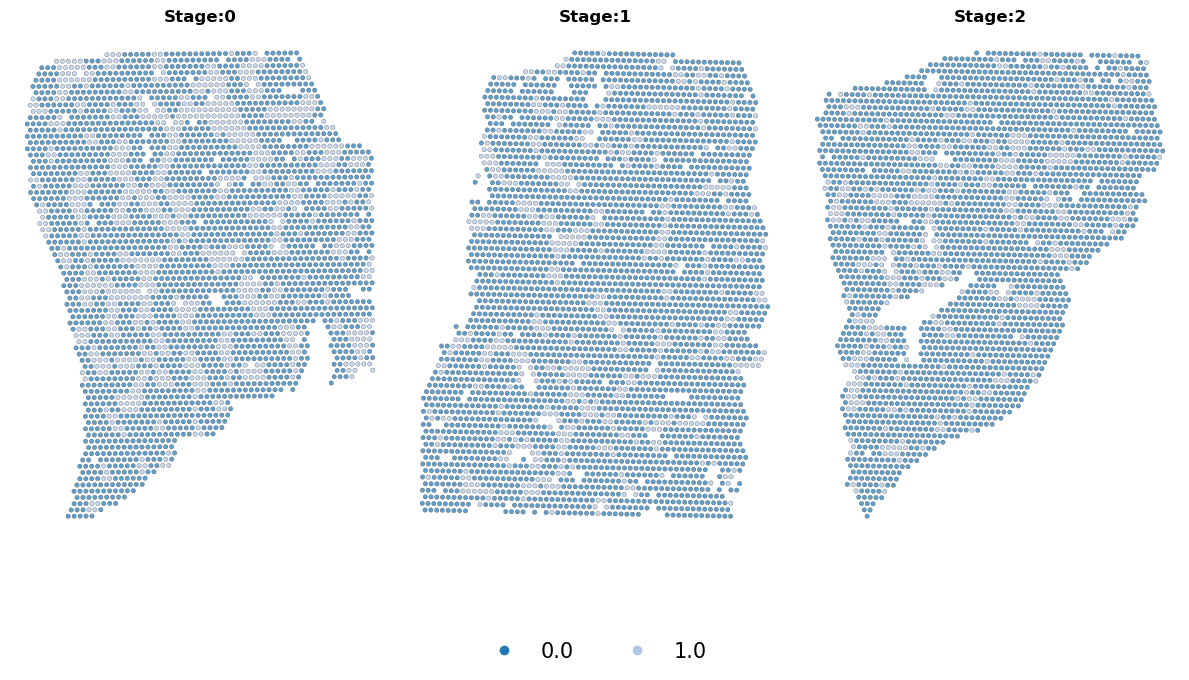

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract all unique cell types across all datasets
all_cell_types = set()
annotation_key = "celltype"
all_cell_types.update(scRNA.obs[annotation_key].unique())

# Create a consistent color map for all cell types
palette = sns.color_palette("tab20", len(all_cell_types))
color_dict = dict(zip(sorted(all_cell_types), palette))

time = sorted(scRNA.obs['day'].unique())

# Plot each dataset side by side with more space for legend
fig, axes = plt.subplots(1, len(time), figsize=(4 * len(time), 7))

if len(time) == 1:  # Ensure axes is iterable when only one dataset
    axes = [axes]

for ax, stage in zip(axes, time):
    # Assign colors based on the global dictionary
    adata = scRNA[scRNA.obs['day'] == stage]
    adata.obs[annotation_key] = adata.obs[annotation_key].astype(str)
    adata.obs["color"] = adata.obs[annotation_key].map(color_dict)

    # Plot spatial coordinates
    ax.scatter(
        adata.obsm["spatial"][:, 0], 
        adata.obsm["spatial"][:, 1], 
        c=adata.obs["color"], 
        s=10, alpha=0.7, edgecolors="k", linewidth=0.2
    )
    
    ax.set_title(f"Stage:{stage}", fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# Create a legend with better spacing
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[cell], markersize=8) 
           for cell in sorted(all_cell_types)]
labels = sorted(all_cell_types)

# Calculate number of columns based on number of cell types
n_cols = min(6, len(labels))  # Max 6 columns

fig.legend(handles, labels, loc='lower center', ncol= 9, fontsize=15, 
           frameon=False, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.2, 1, 1])  # Give more space at bottom for legend
plt.show()

## implausibility

In [27]:
## mosta d0-d1, EOT
'''
Brain → Cavity (84)

Neural crest → Cavity (76)

Cavity → Brain (41)

Brain → Sclerotome (34)

Dermomyotome → Cavity (26)

Heart → Cavity (24)

Connective tissue → Brain (22)

AGM → Brain (20)

Heart → Spinal cord (18)

Brain → Urogenital ridge (17)

Brain → Surface ectoderm (16)

Brain → Liver (8)

Heart → Brain (9)

'''


## mosta d0-d1 REOT mc+lr

'''
Brain → Cavity (94)

Neural crest → Cavity (60)

Cavity → Brain (36)

Brain → Connective tissue (28)

Heart → Cavity (25)

Heart → Brain (23)

Brain → Sclerotome (22)

AGM → Brain (28)

Dermomyotome → Brain (21)

Brain → Surface ectoderm (20)

'''

## mosta d0-d1 REOT lr

'''
Brain → Cavity (91)
Cavity → Brain (27)
Brain → Surface ectoderm (21)

Brain → Connective tissue (18)

Brain → Urogenital ridge (15)

Heart → Spinal cord (22)

Dermomyotome → Brain (16)

Cavity → Spinal cord (31)

Cavity → Blood vessel (10)

'''

'\nBrain → Cavity (91)\nCavity → Brain (27)\nBrain → Surface ectoderm (21)\n\nBrain → Connective tissue (18)\n\nBrain → Urogenital ridge (15)\n\nHeart → Spinal cord (22)\n\nDermomyotome → Brain (16)\n\nCavity → Spinal cord (31)\n\nCavity → Blood vessel (10)\n\n'

NameError: name 'day0_val' is not defined

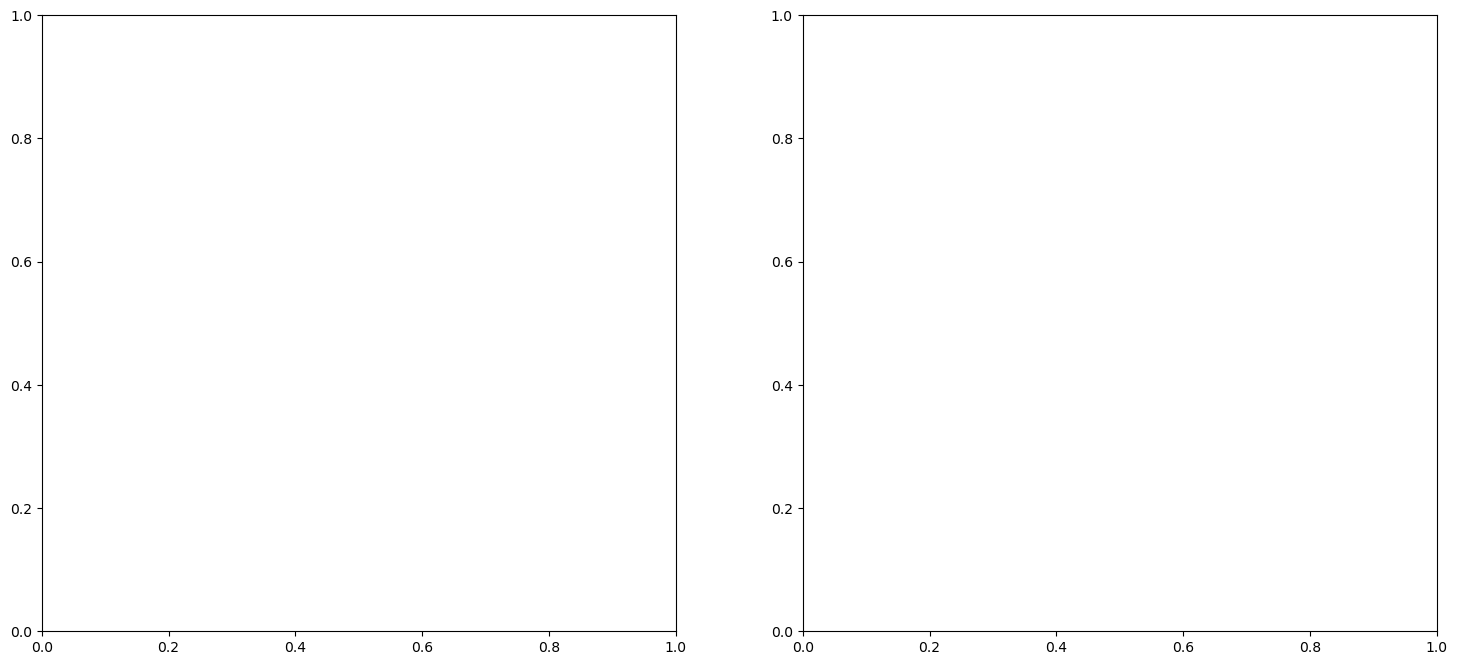

In [28]:
# EOT implausibility transitions stage 0-1 stereoseq
eot_transitions = {
    'Immature MSN->Immature nptxEX': 22,
    'Immature MSN->Immature CMPN': 12,
    'Immature MSN->Immature dpEX': 7,
    'Immature nptxEX->Immature cckIN': 7,
    'Immature nptxEX->Immature MSN': 6
}
# EOT implausibility transitions stage 2-3 mosta
eot_transitions = {
    'Brain → Cavity': 30,
    'Sclerotome → Brain': 28,
    'Dermomyotome → Brain': 26,
    'Brain → Meninges': 25
}




# Create figure for EOT implausibility
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Get unique cell types and create color map
all_cell_types = sorted(scRNA.obs['celltype'].unique())
palette = sns.color_palette("tab20", len(all_cell_types))
color_dict = dict(zip(all_cell_types, palette))

# Left plot (first day)
day0_mask = scRNA.obs['day'] == day0_val
spatial_coords_0 = scRNA.obsm["spatial"][day0_mask]
celltypes_0 = scRNA.obs['celltype'][day0_mask]
colors_0 = [color_dict[ct] for ct in celltypes_0]

axes[0].scatter(spatial_coords_0[:, 0], spatial_coords_0[:, 1], 
               c=colors_0, s=10, alpha=0.7)
axes[0].set_title(f'Stage {day0_val} - Spatial Data', fontsize=16, fontweight='bold')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Right plot (second day)
day1_mask = scRNA.obs['day'] == day1_val
spatial_coords_1 = scRNA.obsm["spatial"][day1_mask]
celltypes_1 = scRNA.obs['celltype'][day1_mask]
colors_1 = [color_dict[ct] for ct in celltypes_1]

axes[1].scatter(spatial_coords_1[:, 0], spatial_coords_1[:, 1], 
               c=colors_1, s=10, alpha=0.7)
axes[1].set_title(f'Stage {day1_val} - Spatial Data', fontsize=16, fontweight='bold')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Add arrows for EOT implausible transitions
arrow_colors = ['red', 'orange', 'purple', 'brown', 'pink']
for idx, (transition, count) in enumerate(eot_transitions.items()):
    source_type, target_type = transition.split('->')
    
    # Get source coordinates from day 0
    source_mask_0 = celltypes_0 == source_type
    source_coords_0 = spatial_coords_0[source_mask_0]
    
    # Get target coordinates from day 1
    target_mask_1 = celltypes_1 == target_type
    target_coords_1 = spatial_coords_1[target_mask_1]
    
    if len(source_coords_0) > 0 and len(target_coords_1) > 0:
        # Sample arrows proportional to count (but max 20 per transition)
        n_arrows = min(20, count, len(source_coords_0), len(target_coords_1))
        
        if n_arrows > 0:
            source_sample_idx = np.random.choice(len(source_coords_0), n_arrows, replace=False)
            target_sample_idx = np.random.choice(len(target_coords_1), n_arrows, replace=False)
            
            source_sample = source_coords_0[source_sample_idx]
            target_sample = target_coords_1[target_sample_idx]
            
            # Draw arrows
            for i in range(n_arrows):
                # Normalize coordinates
                source_x_norm = (source_sample[i, 0] - axes[0].get_xlim()[0]) / (axes[0].get_xlim()[1] - axes[0].get_xlim()[0])
                source_y_norm = (source_sample[i, 1] - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
                
                target_x_norm = (target_sample[i, 0] - axes[1].get_xlim()[0]) / (axes[1].get_xlim()[1] - axes[1].get_xlim()[0])
                target_y_norm = (target_sample[i, 1] - axes[1].get_ylim()[0]) / (axes[1].get_ylim()[1] - axes[1].get_ylim()[0])
                
                # Convert to figure coordinates
                start_x_fig = 0.1 + source_x_norm * 0.35
                start_y_fig = 0.2 + source_y_norm * 0.6
                
                end_x_fig = 0.55 + target_x_norm * 0.35
                end_y_fig = 0.2 + target_y_norm * 0.6
                
                # Add arrow
                fig.add_artist(plt.Line2D([start_x_fig, end_x_fig], [start_y_fig, end_y_fig],
                                         transform=fig.transFigure, 
                                         color=arrow_colors[idx % len(arrow_colors)], 
                                         alpha=0.6, linewidth=2,
                                         marker='>', markersize=6))

# Add legend for transitions
transition_handles = [plt.Line2D([0], [0], color=arrow_colors[i % len(arrow_colors)], 
                                linewidth=3, label=f"{trans} ({count})") 
                     for i, (trans, count) in enumerate(eot_transitions.items())]

# Cell type legend
cell_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=color_dict[cell], markersize=8) 
               for cell in all_cell_types]

# Combine legends
fig.legend(transition_handles, [h.get_label() for h in transition_handles], 
          loc='upper center', ncol=3, fontsize=12, title='Implausible Cell Type Transitions', title_fontsize=14)
fig.legend(cell_handles, all_cell_types, loc='lower center', ncol=9, fontsize=13, frameon=False)

plt.tight_layout(rect=[0, 0.15, 1, 0.9])
plt.show()

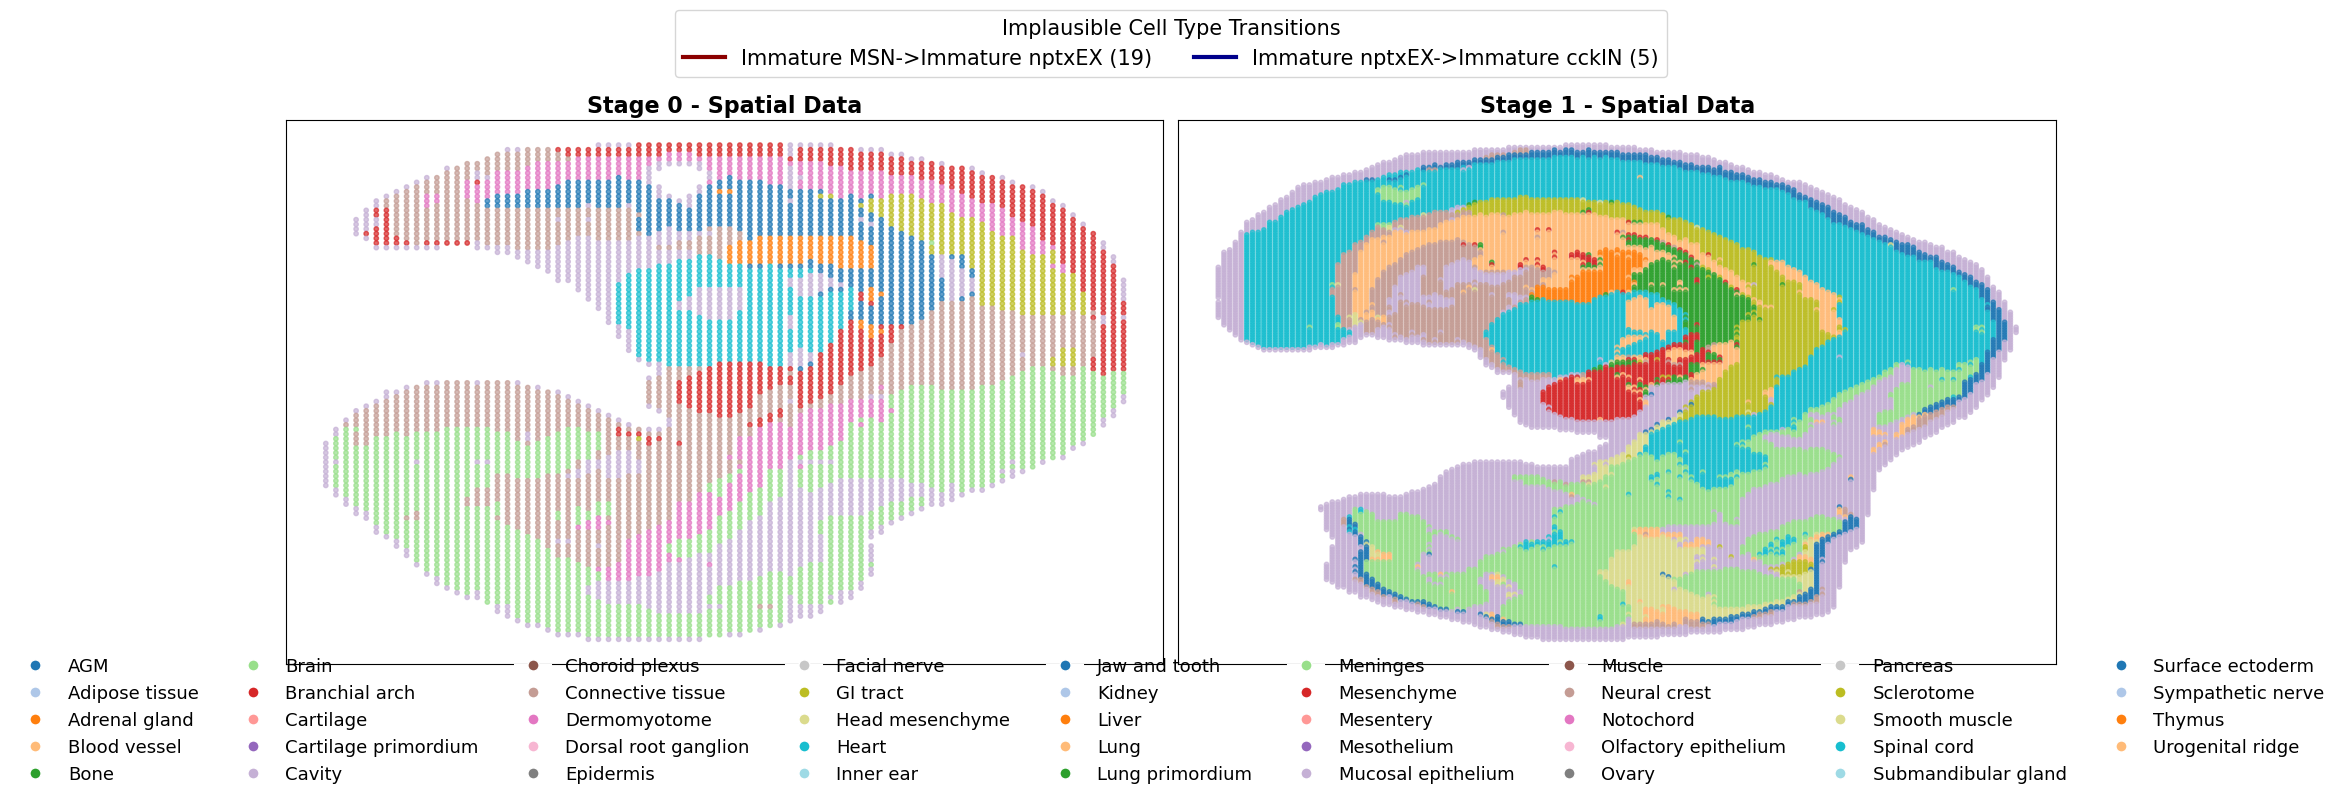

In [ ]:
# Other implausibility transitions  
other_transitions = {
    'Immature MSN->Immature nptxEX': 19,
    'Immature nptxEX->Immature cckIN': 5
}

# Create figure for other implausibility
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left plot (first day)
axes[0].scatter(spatial_coords_0[:, 0], spatial_coords_0[:, 1], 
               c=colors_0, s=10, alpha=0.7)
axes[0].set_title(f'Stage {day0_val} - Spatial Data', fontsize=16, fontweight='bold')
axes[0].set_xticks([])
axes[0].set_yticks([])

# Right plot (second day)
axes[1].scatter(spatial_coords_1[:, 0], spatial_coords_1[:, 1], 
               c=colors_1, s=10, alpha=0.7)
axes[1].set_title(f'Stage {day1_val} - Spatial Data', fontsize=16, fontweight='bold')
axes[1].set_xticks([])
axes[1].set_yticks([])

# Add arrows for other implausible transitions
arrow_colors = ['darkred', 'darkblue']
for idx, (transition, count) in enumerate(other_transitions.items()):
    source_type, target_type = transition.split('->')
    
    # Get source coordinates from day 0
    source_mask_0 = celltypes_0 == source_type
    source_coords_0 = spatial_coords_0[source_mask_0]
    
    # Get target coordinates from day 1
    target_mask_1 = celltypes_1 == target_type
    target_coords_1 = spatial_coords_1[target_mask_1]
    
    if len(source_coords_0) > 0 and len(target_coords_1) > 0:
        # Sample arrows proportional to count
        n_arrows = min(count, len(source_coords_0), len(target_coords_1))
        
        if n_arrows > 0:
            source_sample_idx = np.random.choice(len(source_coords_0), n_arrows, replace=False)
            target_sample_idx = np.random.choice(len(target_coords_1), n_arrows, replace=False)
            
            source_sample = source_coords_0[source_sample_idx]
            target_sample = target_coords_1[target_sample_idx]
            
            # Draw arrows
            for i in range(n_arrows):
                # Normalize coordinates
                source_x_norm = (source_sample[i, 0] - axes[0].get_xlim()[0]) / (axes[0].get_xlim()[1] - axes[0].get_xlim()[0])
                source_y_norm = (source_sample[i, 1] - axes[0].get_ylim()[0]) / (axes[0].get_ylim()[1] - axes[0].get_ylim()[0])
                
                target_x_norm = (target_sample[i, 0] - axes[1].get_xlim()[0]) / (axes[1].get_xlim()[1] - axes[1].get_xlim()[0])
                target_y_norm = (target_sample[i, 1] - axes[1].get_ylim()[0]) / (axes[1].get_ylim()[1] - axes[1].get_ylim()[0])
                
                # Convert to figure coordinates
                start_x_fig = 0.1 + source_x_norm * 0.35
                start_y_fig = 0.2 + source_y_norm * 0.6
                
                end_x_fig = 0.55 + target_x_norm * 0.35
                end_y_fig = 0.2 + target_y_norm * 0.6
                
                # Add arrow
                fig.add_artist(plt.Line2D([start_x_fig, end_x_fig], [start_y_fig, end_y_fig],
                                         transform=fig.transFigure, 
                                         color=arrow_colors[idx], 
                                         alpha=0.7, linewidth=3,
                                         marker='>', markersize=8))

# Add legend for transitions
transition_handles = [plt.Line2D([0], [0], color=arrow_colors[i], 
                                linewidth=3, label=f"{trans} ({count})") 
                     for i, (trans, count) in enumerate(other_transitions.items())]

# Cell type legend
cell_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=color_dict[cell], markersize=8) 
               for cell in all_cell_types]

# Combine legends
fig.legend(transition_handles, [h.get_label() for h in transition_handles], 
          loc='upper center', ncol=2, fontsize=15, title='Implausible Cell Type Transitions', title_fontsize=15)
fig.legend(cell_handles, all_cell_types, loc='lower center', ncol=9, fontsize=13, frameon=False)

plt.tight_layout(rect=[0, 0.15, 1, 0.9])
plt.show()
